In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

In [2]:
# syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))


-0.0166258178256 0.0347767817719 0.0025805871334024376


In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

181

In [4]:
# file = 'data/pantheon.txt'
file = 'data/jla_lcparams.txt'

data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
# X = data.values[:,0]
staterr = data.values[:,2]

In [5]:
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(740, 740) (740, 740)
-0.0166258178256 0.0633448802129 0.0025992186787941202


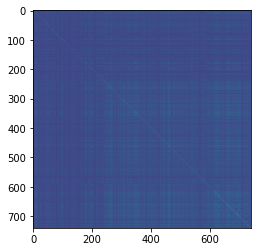

In [6]:
# df_syscov = pd.DataFrame(syscov)
# sns.heatmap(df_syscov, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
#             robust=True)

# plt.savefig("cov_sys.png", dpi=300)
plt.imshow(covfull)

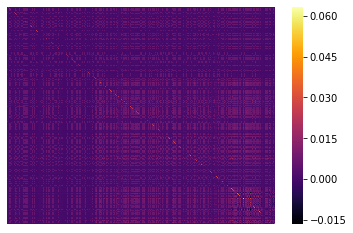

In [7]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno',
            vmax=maxcov, vmin=mincov,robust=True)

In [8]:
np.min(syscov.diagonal()) #checking non-negatives

0.000101239339154

In [9]:
syscov[0,1] == syscov[1,0]

True

In [10]:
np.min(syscov)

-0.0166258178256

In [11]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
eigenval, eigenvec = sp.linalg.eigh(covfull)

In [12]:
np.shape(eigenval), np.shape(eigenvec)

((740,), (740, 740))

The eigenvalues are positive?

In [13]:
np.min(eigenval)

0.007294097912483412

In [14]:
count = 0

for i in range(len(eigenvec)):
    for j in range(len(eigenvec)):
        if np.iscomplex(eigenvec[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


In [15]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

In [16]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))

(740, 740)


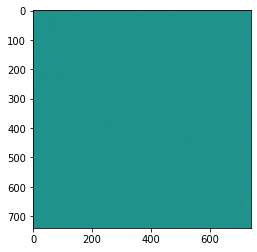

In [17]:
print(np.shape(ortM))
plt.imshow(ortM)

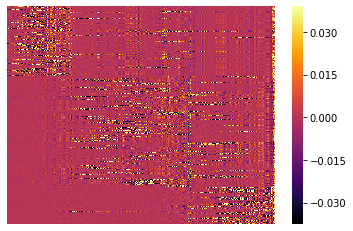

In [18]:
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

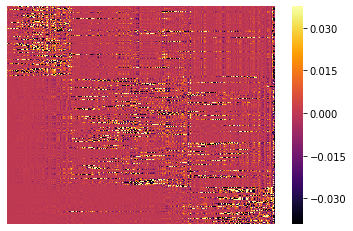

In [19]:
df_eig = pd.DataFrame(eigenvec)
sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

### Generate eigenvectors matrix with noise

In [20]:
numMatrix = 100
noise_factor = 1e-5
# scaler = StandardScaler()
# feature_range=(-1,1)
# scaler.fit(ortM)
eigenvecdata = np.zeros((numMatrix, 740, 740))
for i in range(numMatrix): 
    eigenvecdata[i] = ortM + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=ortM.shape) 
#     eigenvecdata[i] = scaler.transform(eigenvecdata[i])


(100, 740, 740)
(20, 740, 740) (80, 740, 740)


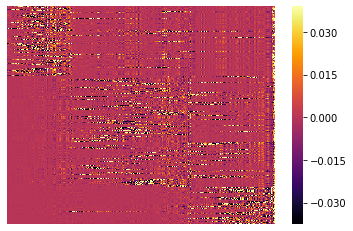

In [21]:
print(np.shape(eigenvecdata))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
evec_train, evec_test = np.split(eigenvecdata, indx, axis=0)
print(np.shape(evec_test), np.shape(evec_train))
sns.heatmap(pd.DataFrame(evec_test[0, :, :]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

In [22]:
# input_cov = Input(shape=(1048,))

input_cov = Input(shape=(740, 740, 1))

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(input_cov)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = tf.keras.Model(input_cov, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [23]:
autoencoder_train = autoencoder.fit(evec_train, evec_train,
                epochs=20,
                batch_size=32,
#                 shuffle=True,
                validation_data=(evec_test, evec_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
3/3 [==============================] - 18s 6s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 2/20
3/3 [==============================] - 22s 7s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 3/20
3/3 [==============================] - 20s 7s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 4/20
3/3 [==============================] - 18s 6s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 5/20
3/3 [==============================] - 16s 5s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 6/20
3/3 [==============================] - 13s 4s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 7/20
3/3 [==============================] - 12s 4s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 8/20
3/3 [==============================] - 12s 4s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 9/20
3/3 [==============================] - 12s 4s/step - loss: -7.3887e-05 - val_loss: -7.3952e-05
Epoch 10/20
3/3 [=============================

In [24]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 740, 740, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 740, 740, 2)       20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 370, 370, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 370, 370, 2)       38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 185, 185, 2)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 185, 185, 2)       38        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 93, 93, 2)        

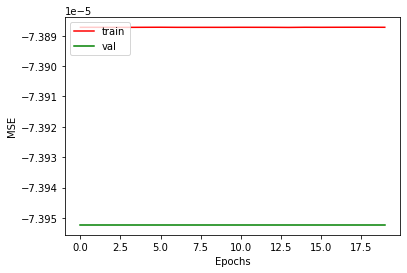

In [25]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [26]:
print(np.shape(evec_test))
decoded_imgs = autoencoder.predict(evec_test)
decoded_imgs[0, :, :, 0]

(20, 740, 740)


array([[-0.36722472, -0.6300983 , -0.53568655, ..., -0.3331744 ,
        -0.26497644, -0.15709181],
       [-0.49325103, -0.9468061 , -0.8792521 , ..., -0.48452047,
        -0.4352352 , -0.2092138 ],
       [-0.50674486, -0.96052766, -0.8733525 , ..., -0.4733061 ,
        -0.43217555, -0.21043633],
       ...,
       [-0.49578857, -0.9076072 , -0.8093141 , ..., -0.36314115,
        -0.33477265, -0.18001363],
       [-0.46549565, -0.85757065, -0.7660716 , ..., -0.32916492,
        -0.31673583, -0.17429331],
       [-0.4363099 , -0.67537177, -0.57689834, ..., -0.25781083,
        -0.2394145 , -0.13792355]], dtype=float32)

(20, 740, 740, 1)
(20, 740, 740, 1)


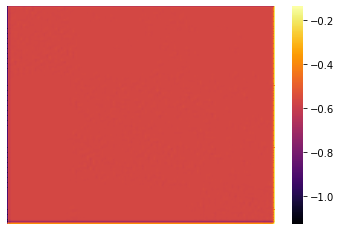

In [27]:
print(np.shape(decoded_imgs))
# plt.imshow(decoded_imgs[3, : , :, 0])
print(np.shape(decoded_imgs))
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

(20, 740, 740, 1)


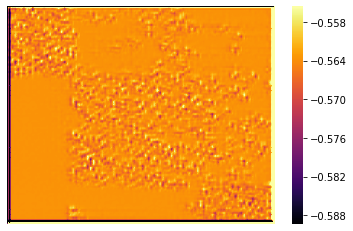

In [28]:
print(np.shape(decoded_imgs))
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(decoded_imgs[0, :, :, 0])), 
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

(20, 740, 740)


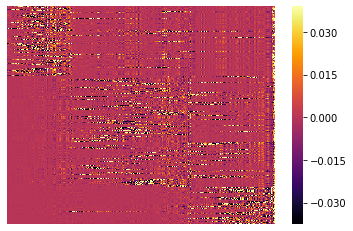

In [29]:
print(np.shape(evec_test))
# plt.imshow(evec_test[3, : , :])
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[0, :, :])),
sns.heatmap(pd.DataFrame(evec_test[0, :, :]),
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

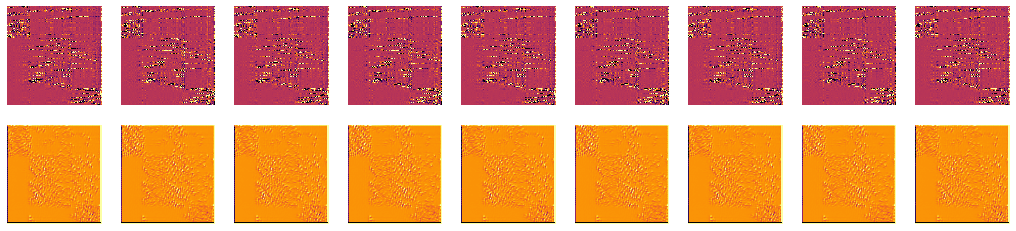

In [30]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(evec_test[i, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
#     sns.heatmap(pd.DataFrame(decoded_imgs[i, :, :, 0]),
    sns.heatmap(decoded_imgs[i, :, :, 0],
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)

plt.show()

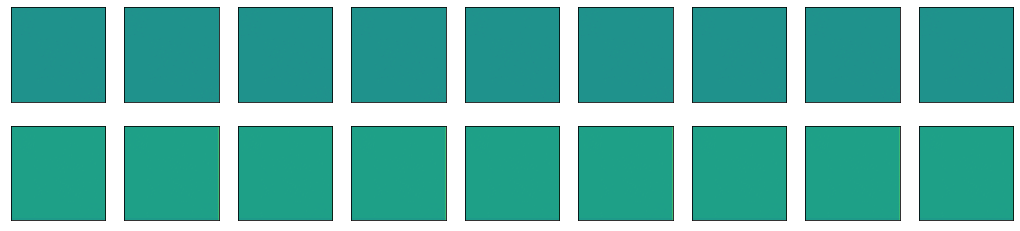

In [31]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     plt.imshow(scaler.inverse_transform(evec_test[i, :, :]))
    plt.imshow(evec_test[i, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [32]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(evec_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))

-0.9801095606945928 -1.1246461
